# Reweighting

*Properties of the reweighting procedure for observable $\Sigma$*

## Function definitions

- load the necessary modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

- read complex eigenvalues of one configuration:

In [2]:
def readCEVs(eigFile):
# eigFile - name of .eig file with eigenvalues
    cevs = np.loadtxt(eigFile)
    return np.array([np.complex128(cev[0] + cev[1] * 1j) for cev in cevs])

- read complex eigenvalues of all configurations at once:

In [3]:
def readAllCEVs(eigFilesList):
# eigFilesList - list of .eig file names
    f = open(eigFilesList, "r")
    allCEVs = []
    for eigFileName in f:
        allCEVs.append(readCEVs(eigFileName.strip()))
    f.close()
    return allCEVs

- absolute value of topological charge is equal to the number of zero modes:

In [4]:
def countZeros(cevs):
# cevs - complex eigenvalues of one configuration
    return len([cev for cev in cevs if abs(cev) < 1e-12])

- computes determinant of a massive overlap operator using eigenvalues:

In [5]:
def detM(cevs, qm, nmz, out):
# cevs - complex eigenvalues
# qm - quark mass
# nmz - numerical normalization (about 0.63 is optimal)
# out - print complex p if True
    f = 1.0 - qm / 2.0
    p = np.complex128(1 + 0j)
    for i in range(len(cevs)):
        p *= (f * cevs[i] + qm) * nmz
    if out: print(p)
    return p.real

- computes normalized determinants (max = 1) of an ensemble:

In [6]:
def detEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]
    dmax = max(dets)
    return [d / dmax for d in dets]

- sort determinants according to absolute topological charge:

In [7]:
def QdetEnMax1(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass

    # compute determinants for all configuration
    dets = [detM(cevs, qm, 0.63, False) for cevs in allCEVs]

    # normalize determinants to max is equal to one
    dmax = max(dets)
    dets = [d / dmax for d in dets]

    # compute absolute topological charge
    Qs = [countZeros(cevs) for cevs in allCEVs]

    # find maximal topological charge
    Qmax = int(max(Qs))
    print("Qmax =", Qmax)

    # create Qmax + 1 empty lists
    Qdet = []
    for i in range(Qmax + 1): Qdet.append([])

    # add determinants according to topological charge
    for i in range(len(dets)):
        Qdet[Qs[i]].append(dets[i])
        
    # how many entries are in each topological sector
    print([len(Qdet[i]) for i in range(Qmax + 1)])
    print()
    
    return Qdet

- compute $\Sigma$ from complex eigenvalues for a given quark mass `qm`:

In [8]:
def sigma(cevs, qm, out):
# cevs - list of complex eigenvalues
# qm - quark mass
# out - if True sigma is printed
    f = 1.0 - qm / 2.0
    s = np.complex128(0.0 + 0.0j) # sum
    for i in range(len(cevs)):
        s += (1.0 - 0.5 * cevs[i]) / (f * cevs[i] + qm)
    # len(cevs) is 2 * L^2 because of 2 spinor components
    sig = s / (len(cevs) * 0.5) # division by L^2
    if out: print(sig) # imaginary part should be near zero 
    return sig.real

- compute $\Sigma$ for a given quark mass `qm` for all configurations:

In [9]:
def sigmaEn(allCEVs, qm):
# allCEVs - eigenvalues for all configurations
# qm - quark mass
    sigmas = [sigma(cevs, qm, False) for cevs in allCEVs]
    return sigmas

## Examples

- read complex eigenvalues of one configuration:

In [10]:
cevs = readCEVs("/mnt/e/Jaime/b4_20x20Ov/Eig/L020x020_b04000i00001-HO.eig")
cevs[0]

(0.00213644822675577-0.0653324731085987j)

- compute determinant for quark mass 0.05:

In [11]:
detM(cevs, 0.05, 0.63, True)

(2.6583807559420576-1.992850329202156e-14j)


2.6583807559420576

- compute absolute value of topological charge:

In [12]:
countZeros(cevs)

1

In [13]:
sigma(cevs, 0.05, True)

(0.12887504928843335-3.924811864397526e-16j)


0.12887504928843335

## Results

- read complex eigenvalues of all configurations from an ensemble:

In [14]:
%%time
allCEVs = readAllCEVs("/mnt/e/Jaime/b4_20x20Ov/eigFiles.list")

CPU times: user 48 s, sys: 4.73 s, total: 52.8 s
Wall time: 1min 45s


### Check $\Sigma$ reweighting

In [15]:
def sigVqm(allCEVs, maxNf, qmMin, qmMax, qmStep):
    qms = np.arange(qmMin, qmMax, qmStep)
    sigqm = [[qms, []] for i in range(maxNf + 1)]
    for qm in qms:
        dets = detEnMax1(allCEVs, qm)
        sigmas = sigmaEn(allCEVs, qm)
        for Nf in range(maxNf + 1):
            detNf = [d**Nf for d in dets]
            sumdetNf = sum(detNf)
            sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
            sigqm[Nf][1].append(sum(sigdetNf))
    return sigqm

In [16]:
%%time
sigqm = sigVqm(allCEVs, 2, 0.005, 0.151, 0.005)

CPU times: user 13min 40s, sys: 95.4 ms, total: 13min 40s
Wall time: 13min 40s


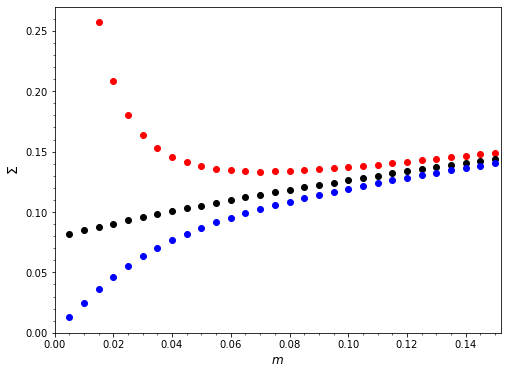

In [17]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m$", fontsize = 12)
p.set_ylabel(r"$\Sigma$", fontsize = 14)
p.set_xlim(0.0, 0.152)
p.set_ylim(0.0, 0.27)
p.set_xticks(np.arange(0, 0.152, 0.005), minor = True)
p.set_yticks(np.arange(0, 0.27, 0.01), minor = True)

p.scatter(sigqm[0][0], sigqm[0][1], color = "red")
p.scatter(sigqm[1][0], sigqm[1][1], color = "black")
p.scatter(sigqm[2][0], sigqm[2][1], color = "blue");

- correction for $\beta$, i.e. $g = 1/\sqrt{\beta}$:

In [18]:
beta = 4.0
g = 1.0 / np.sqrt(beta)
gsigqm = [[[sigqm[j][k][i] / g for i in range(len(sigqm[j][k]))] for k in range(len(sigqm[j]))] for j in range(len(sigqm))]

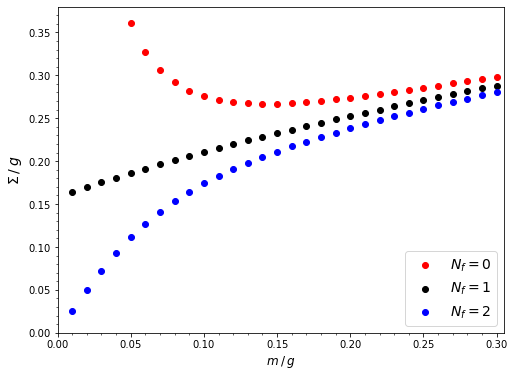

In [19]:
fig, p = plt.subplots(figsize = (8, 6))
p.set_xlabel("$m\:/\:g$", fontsize = 12)
p.set_ylabel(r"$\Sigma\:/\:g$", fontsize = 14)
p.set_xlim(0.0, 0.305)
p.set_ylim(0.0, 0.38)
p.set_xticks(np.arange(0, 0.305, 0.01), minor = True)
p.set_yticks(np.arange(0, 0.38, 0.01), minor = True)

p.scatter(gsigqm[0][0], gsigqm[0][1], color = "red", label = "$N_f = 0$")
p.scatter(gsigqm[1][0], gsigqm[1][1], color = "black", label = "$N_f = 1$")
p.scatter(gsigqm[2][0], gsigqm[2][1], color = "blue", label = "$N_f = 2$")
p.legend(loc = "lower right", fontsize = 14);

### $\Sigma$ distributions

#### $\Sigma$ distribution (quenched) / m = 0.05

In [20]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)

CPU times: user 4.81 s, sys: 59 µs, total: 4.81 s
Wall time: 4.8 s


In [21]:
sum(sigmas) / len(sigmas) # average sigma (quenched)

0.13781632229894217

In [22]:
(min(sigmas), max(sigmas))

(0.05161850479558079, 0.3825240626525837)

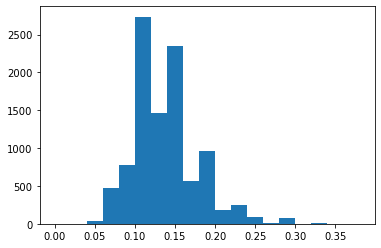

In [23]:
plt.hist(sigmas, bins = [r for r in np.arange(0.0, 0.4, 0.02)]);

#### $\Sigma$ times determinant (1 flavor) per configuration distribution / m = 0.05

In [24]:
%%time
dets = detEnMax1(allCEVs, 0.05)
sumdet1 = sum(dets)

CPU times: user 3.12 s, sys: 46 µs, total: 3.12 s
Wall time: 3.12 s


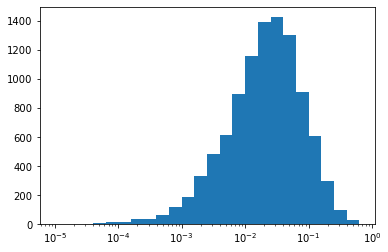

In [25]:
plt.xscale('log')
plt.hist(dets, bins = [10.0**r for r in np.arange(-5.0, 0, 0.2)]);

In [26]:
%%time
sigdet1 = [sigmas[i] * dets[i] / sumdet1 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet1))
print()

sigma =  0.10531380923744617

CPU times: user 1.89 ms, sys: 10 µs, total: 1.9 ms
Wall time: 1.9 ms


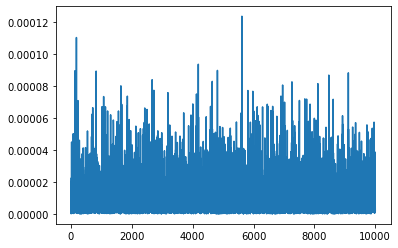

In [27]:
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

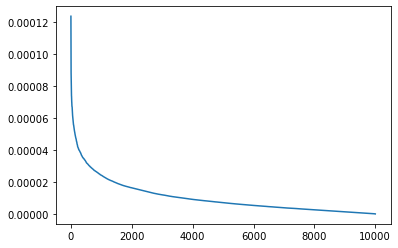

In [28]:
sigdet1.sort(reverse = True)
plt.plot(range(1, len(sigdet1) + 1), sigdet1);

In [29]:
(min(sigdet1), max(sigdet1))

(5.10535900242812e-09, 0.00012364615039179075)

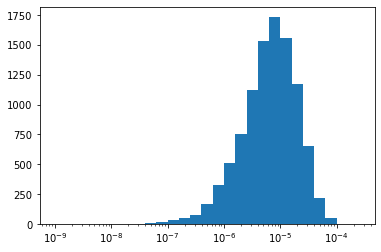

In [30]:
plt.xscale('log')
plt.hist(sigdet1, bins = [10.0**r for r in np.arange(-9.0, -3.5, 0.2)]);

#### $\Sigma$ times squared determinant (2 flavors) per configuration distribution / m = 0.05

In [31]:
%%time
dets = detEnMax1(allCEVs, 0.05)
det2 = [d**2 for d in dets]
sumdet2 = sum(det2)

CPU times: user 3.13 s, sys: 38 µs, total: 3.13 s
Wall time: 3.13 s


In [32]:
%%time
sigmas = sigmaEn(allCEVs, 0.05)
sigdet2 = [sigmas[i] * det2[i] / sumdet2 for i in range(len(sigmas))]
print("sigma = ", sum(sigdet2))
print()

sigma =  0.08698086336108671

CPU times: user 4.61 s, sys: 0 ns, total: 4.61 s
Wall time: 4.61 s


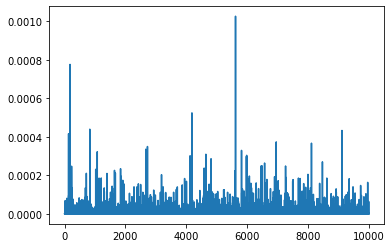

In [33]:
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

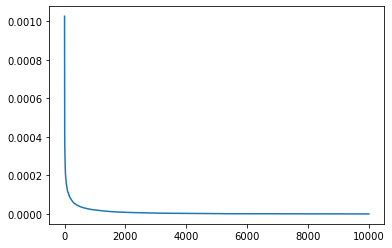

In [34]:
sigdet2.sort(reverse = True)
plt.plot(range(1, len(sigdet2) + 1), sigdet2);

In [35]:
(min(sigdet2), max(sigdet2))

(2.663528532107877e-13, 0.0010261970380362583)

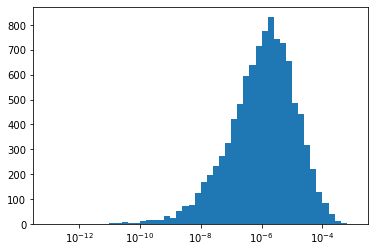

In [36]:
plt.xscale('log')
plt.hist(sigdet2, bins = [10.0**r for r in np.arange(-13.0, -2.8, 0.2)]);

### Cumulative plots

In [37]:
def cumSigmaNf(sigmas, dets, Nf):
    detNf = [d**Nf for d in dets]
    sumdetNf = sum(detNf)
    sigdetNf = [sigmas[i] * detNf[i] / sumdetNf for i in range(len(sigmas))]
    sigmaNf = sum(sigdetNf)
    sigdetNf.sort(reverse = True)
    csigdetNf = [sum(sigdetNf[:i]) / sigmaNf for i in range(1, len(sigdetNf) + 1)]
    return sigmaNf, csigdetNf 

In [38]:
def cumSigma(allCEVs, qm, flavors):
    fig, p = plt.subplots(figsize = (8, 5))  
    print("Nf    sigma     50%   90%   99%")
    print("===============================")
    dets = detEnMax1(allCEVs, qm)
    sigmas = sigmaEn(allCEVs, qm)
    for flavor in flavors:
        Nf, NfColor, NfLabel = flavor
        sigmaNf, csNf = cumSigmaNf(sigmas, dets, Nf)
        s50 = len([cs for cs in csNf if cs <= 0.50])
        s90 = len([cs for cs in csNf if cs <= 0.90])
        s99 = len([cs for cs in csNf if cs <= 0.99])
        print("%2d  %9.7f %5d %5d %5d " % (Nf, sigmaNf, s50, s90, s99))
        p.plot(range(1, len(csNf) + 1), csNf, color = NfColor, label = NfLabel)
    p.legend(loc = "lower right", fontsize = 14)

#### m = 0.2

Nf    sigma     50%   90%   99%
 1  0.1593495  3058  7675  9579 
 2  0.1570204  1627  5893  8830 
 4  0.1536070   365  2584  6153 
 6  0.1514763    91   910  3242 


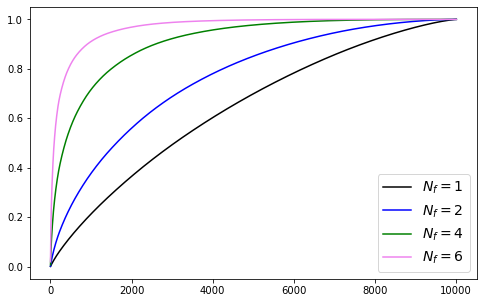

In [39]:
cumSigma(allCEVs, 0.2, [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]])

#### m = 0.1

Nf    sigma     50%   90%   99%
 1  0.1262986  2311  6828  9251 
 2  0.1191389   806  4038  7529 
 4  0.1099706    87   899  3132 
 6  0.1039011    13   178   938 


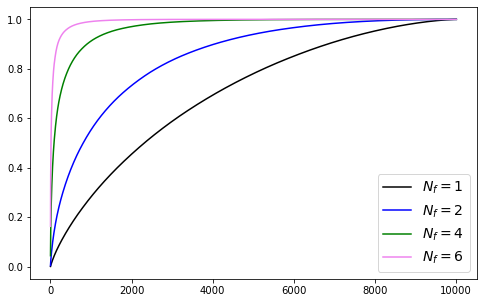

In [40]:
cumSigma(allCEVs, 0.1, [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]])

#### m = 0.05

Nf    sigma     50%   90%   99%
 1  0.1053138  1789  5992  8791 
 2  0.0869809   412  2611  5974 
 4  0.0653109    16   275  1325 
 6  0.0561419     1    23   203 


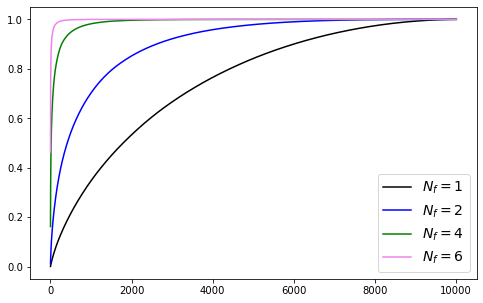

In [41]:
cumSigma(allCEVs, 0.05, [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]])

#### m = 0.01

Nf    sigma     50%   90%   99%
 1  0.0848037  1094  4497  7519 
 2  0.0248797   223  1499  3796 
 4  0.0126283     4    68   359 
 6  0.0113806     0     8    58 


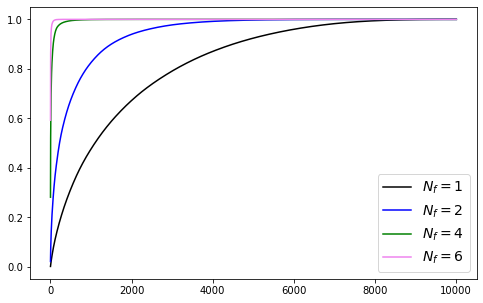

In [42]:
cumSigma(allCEVs, 0.01, [[1, "black", "$N_f = 1$"], [2, "blue", "$N_f = 2$"],
    [4, "green", "$N_f = 4$"], [6, "violet", "$N_f = 6$"]])

*Hip, 2023-08-08*